Silent substitution problems
============================

Silent substitution stimuli typically take the form of pulses or temporal modulations of photoreceptor-directed contrast presented against a background spectrum to which an observer has adapted. 

The background spectrum serves to maintain a set pattern of photoreceptor activations and the modulation spectrum increases activation of the targeted photoreceptor(s) without altering activation of the others. 


`pysilsub.problems.SilentSubstitutionProblem`
---------------------------------------------

This class serves as the interface for defining, solving, and visualising silent substitution problems. It extends `pysilsub.devices.StimulationDevice` with [properties](https://realpython.com/python-property/) (i.e., managed attributes), and methods for finding and plotting solutions.

Instances are created in the same ways as `StimulationDevice` instances, so for convenience let's use the `.from_package_data(...)` constructor described [here](03b_stimulation_devices.ipynb#Package-data). 


In [1]:
from pysilsub import problems

ssp = problems.SilentSubstitutionProblem.from_package_data('STLAB_1_York')

The properties of a `SilentSubstitutionProblem` are:

  - `background` - the background spectrum
  - `ignore` - which photoreceptors to ignore
  - `silence` - which photoreceptors to (nominally) silence
  - `target` - which photoreceptors to target
  - `target_contrast` - desired target contrast as a percentage of the background spectrum
  
For more details on any of the above, just ask:

In [2]:
ssp.ignore?

Type:        property
String form: <property object at 0x7f8ff256dfd0>
Docstring:  
Photoreceptor(s) to be ignored.

Setting the *ignore* property internally conditions the silent
substitution problem such that the specified photoreceptor(s) will be
ignored by the solvers (enabling them to find more contrast on the
targeted photoreceptors). For example, one may choose to *ignore* rods
when working in the photopic range (>300 cd/m2) as they are often
assumed to be saturated and incapable of signalling at these light
levels::

    ssp.ignore = ['rh']

One may also choose to ignore both rods and melanopsin::

    ssp.ignore = ['rh', 'mel']

Or both rods and the non-functional cone of a dichromat::

    ssp.ignore = ['rh', 'lc']

In the event that you don't want to ignore any photoreceptors, you must
still pass::

    ssp.ignore = [None]

Setting the *ignore* property is an essential step for conditioning a
silent substitution problem.

Raises
------
SilSubProblemError if ignore not specif

Defining a problem
------------------

Problems are defined by setting the required/desired properties. The `ignore`, `target` and `silence` properties **must** be set and should together account for all photoreceptors ('sc', 'mc', 'lc', 'rh', 'mel'). The `background` and `target_contrast` properties may need to be set, depending on the constraints of the research question and which solver you intend to use.

In [3]:
print(f'Retinal photoreceptors:\n{ssp.observer.photoreceptors}\n')

# These properties *must* be set
ssp.ignore = ['rh']
ssp.target = ['sc']
ssp.silence = ['mc', 'lc', 'mel']

# These properties may need to be set, 
# depending on which solver you intend to use
ssp.background = [.5] * ssp.nprimaries
ssp.target_contrast = .2
ssp.print_problem()

Retinal photoreceptors:
['sc', 'mc', 'lc', 'rh', 'mel']

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_1 (binocular, left eye)
Observer: ColorimetricObserver(age=32, field_size=10)
Ignoring: ['rh']
Silencing: ['mc', 'lc', 'mel']
Targeting: ['sc']
Target contrast: [ 0.2]
Background: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]




Here we have said that we want to modulate S-cone contrast by 20% relative to a background of all primaries at half-maximum, whilst ignoring the rod photoreceptors and minimising changes in activation of M-cones, L-cones and melanopsin. 

Finding a solution
------------------

After defining a problem it is easy to find a solution, providing one actually exists within the gamut of the device. 

Two solvers are available for this. For some background on these methods, further details on implementation, and a variety of use cases, please refer to the [worked examples](05_examples.rst).

#### `.linalg_solve()` 
This method uses linear algebra for unidirectional scaling of the primaries and works only if the `background` and `target_contrast` properties have been set.

In [4]:
linalg_solution = ssp.linalg_solve()
print(linalg_solution)

Primary
0    0.690308
1    0.691431
2    0.466195
3    0.408491
4    0.340666
5    0.481720
6    0.592775
7    0.482610
8    0.401599
9    0.457392
dtype: float64


#### `.optim_solve(...)` 
This method uses numerical optimisation methods from `scipy.optimize`. If the `background` property was not set, the background spectrum will also be optimised. 

In [5]:
optim_solution = ssp.optim_solve(**{'options':{'disp':False}})
print(optim_solution.x)

~~~~~~~~~~~~~~~~~~~~~~~ optim_solve ~~~~~~~~~~~~~~~~~~~~~~~~
> Performing local optimization with SLSQP.
[ 0.67844402  0.95669101  0.03640049  0.01812555  0.81756096  0.78596596
  0.09764588  0.8009693   0.28556816  0.14244418]


Visualising a solution
----------------------

Having found a solution, you will probably want to see what it looks like. 

`.plot_solution(...)` makes a nice plot showing the predicted background and modulation spectra alongside their CIE *xy* chromaticity coordinates and *a*-opic irradiance. 

 Background settings: [2047, 2047, 2047, 2047, 2047, 2047, 2047, 2047, 2047, 2047]
 Modulation settings: [2826, 2831, 1909, 1672, 1395, 1972, 2427, 1976, 1644, 1873]


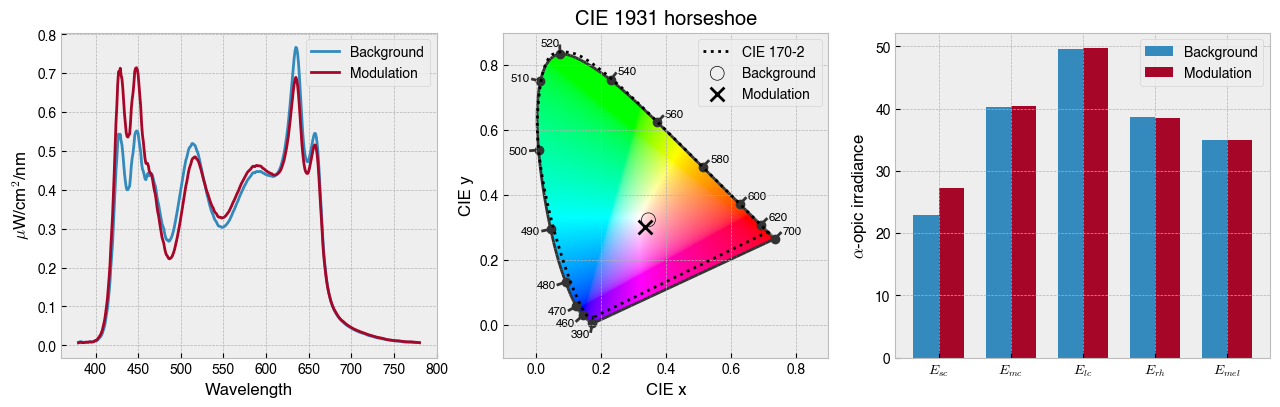

In [6]:
# Linear algebra solution
fig = ssp.plot_solution(linalg_solution)
print(f' Background settings: {ssp.w2s(ssp.background)}')
print(f' Modulation settings: {ssp.w2s(linalg_solution)}')

 Background settings: [2047, 2047, 2047, 2047, 2047, 2047, 2047, 2047, 2047, 2047]
 Modulation settings: [2778, 3917, 149, 74, 3347, 3218, 399, 3279, 1169, 583]


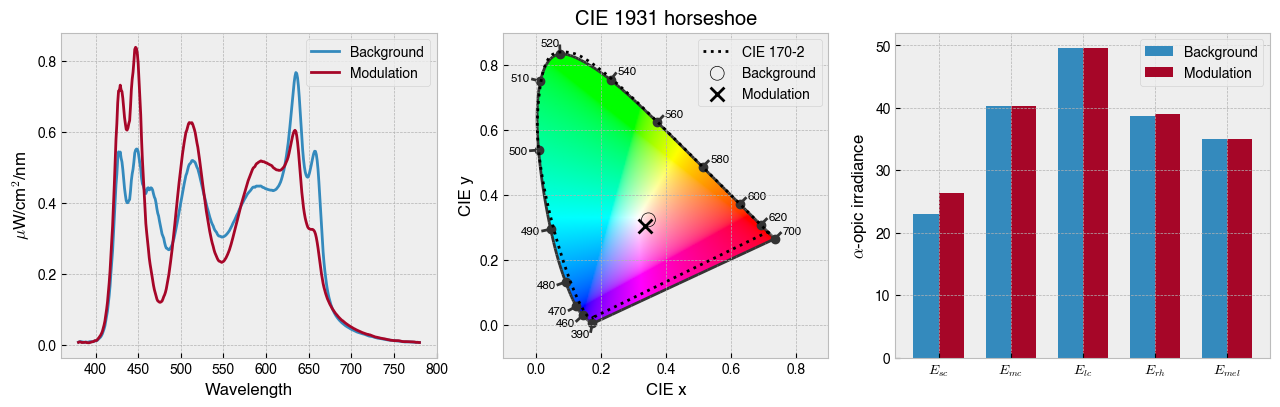

In [7]:
# Optimisation solution
fig = ssp.plot_solution(optim_solution.x)
print(f' Background settings: {ssp.w2s(ssp.background)}')
print(f' Modulation settings: {ssp.w2s(optim_solution.x)}')

Note that the above solutions are somewhat different due to the contrasting approaches of the solvers, but they achieve the same aim of finding 20% contrast on S-cones relative to the background spectrum without changing activation in the other photoreceptors. 